In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
df_jpm = pd.read_csv('df_jpm.csv')

In [3]:
df_jpm.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MktRF,SMB,HML,RF,RMW,CMA,SMB_5,yest_close,stock_return,log_return
0,2016-05-18,61.700001,64.169998,61.689999,64.040001,57.172466,24007100,0.10,0.10,0.83,0.001,-1.34,-0.65,0.14,55.047691,0.038599,0.000000
1,2016-05-19,63.529999,64.220001,62.900002,63.389999,56.592175,16076200,-0.33,-0.32,-0.30,0.001,0.39,-0.01,-0.31,57.172466,-0.010150,-0.010202
2,2016-05-20,63.860001,64.190002,63.369999,63.509998,56.699303,11862000,0.75,0.90,-0.30,0.001,-0.39,-0.38,0.84,56.592175,0.001893,0.001891
3,2016-05-23,63.450001,63.869999,63.160000,63.459999,56.654667,9347500,-0.18,0.26,-0.32,0.001,-0.21,0.08,0.24,56.699303,-0.000787,-0.000788
4,2016-05-24,63.939999,64.769997,63.810001,64.540001,57.618855,13839400,1.43,0.68,-0.34,0.001,-0.10,-0.39,0.61,56.654667,0.017019,0.016875


Optimization terminated successfully.
         Current function value: 4.635917
         Iterations: 3
         Function evaluations: 48
         Gradient evaluations: 8


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: OptimizeWarning: Unknown solver options: xtol


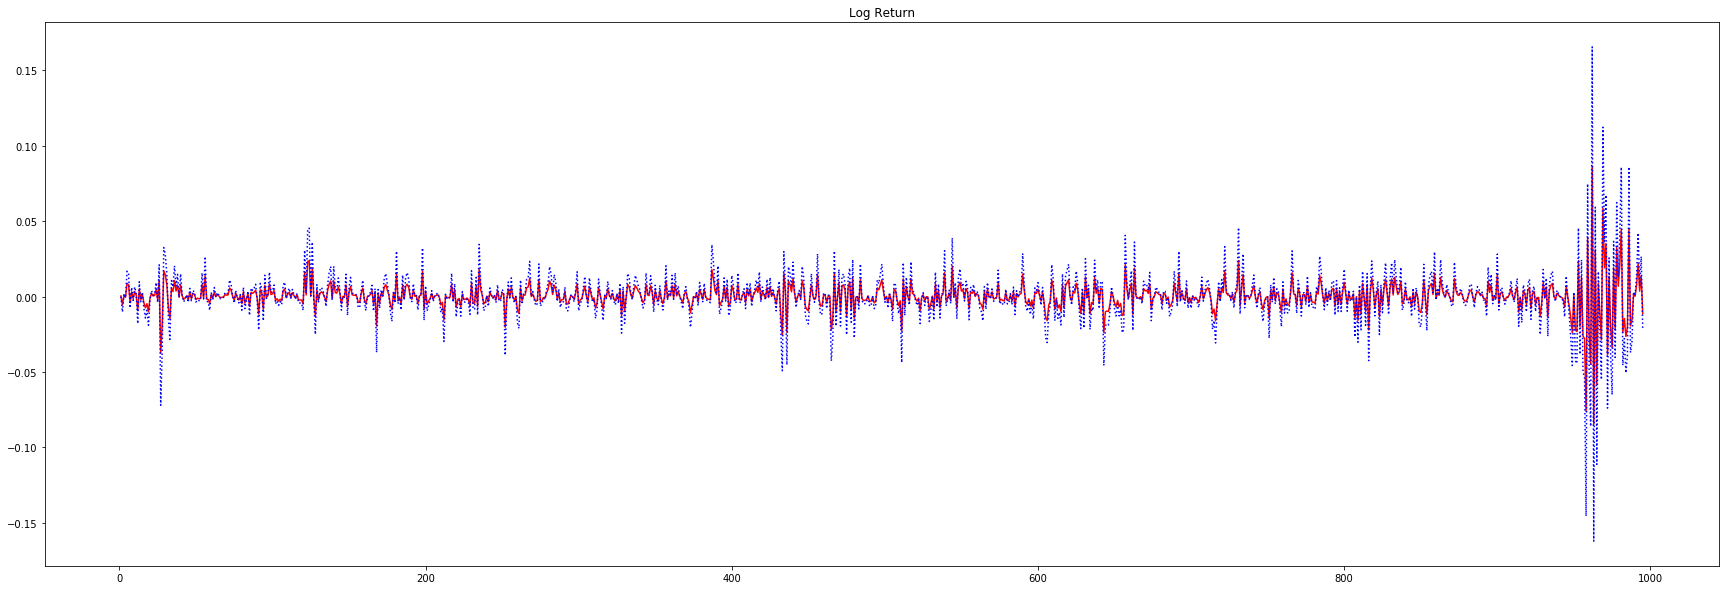

In [9]:
#(Close price today/  yest close price-1)
#Sum of squared error 

def Kalman_Filter(Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = param0[0]#parameter coeff env eq link Y and component
    T = param0[1]# auto regressive comp
    H = param0[2]#volatility
    Q = param0[3]
    #temp = param0[4]
    "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    KF_Dens = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
            v[s]=Y[s-1]-Z*u_predict[s-1] 
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_update[s]; 
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
            KF_Dens[s] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]     
            Likelihood = np.sum(KF_Dens[1:-1])  
            return Likelihood


def Kalman_Smoother(params, Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]
    #temp = params[4]
    "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
            v[s]=Y[s-1]-Z*u_predict[s-1]    
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_update[s]; 
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q

            u_smooth = np.zeros(S)
            P_smooth = np.zeros(S)
            u_smooth[S-1] = u_update[S-1]
            P_smooth[S-1] = P_update[S-1]    
    for  t in range(S-1,0,-1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[t])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
    u_smooth = u_smooth[0:-1]
    return u_smooth


plt.figure(figsize=(30,10))
plt.title('Log Return')
p_t = df_jpm['log_return']
T = df_jpm.shape[0]
Y=p_t
param0 = np.array([1.3, 1, 0.8, 1])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
y_pred = Kalman_Smoother(param_star.x, Y)
timevec = np.linspace(1,T,T)
plt.plot(timevec, y_pred,'r',timevec, Y,'b:')

In [7]:
mse = mean_squared_error(Y,y_pred)
rmse = np.sqrt(mse)
print('RMSE-------',rmse)
print('R-Squared--',r2_score(Y,y_pred))

RMSE------- 0.008740972718984273
R-Squared-- 0.7714935920475364
